In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/test/sherlock/')

import os
import torch
import numpy as np
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from mxtorch import transforms as tfs
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

voc_root = './data/VOCdevkit/VOC2012'

def read_images(root=voc_root, train=True):
    txt_fname = root + '/ImageSets/Segmentation/' + ('train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root, 'JPEGImages', i+'.jpg') for i in images]
    label = [os.path.join(root, 'SegmentationClass', i+'.png') for i in images]
    return data, label

def rand_crop(data, label, height, width):
    '''
    data is PIL.Image object
    label is PIL.Image object
    '''
    data, rect = tfs.RandomCrop((height, width))(data)
    label = tfs.FixedCrop(*rect)(label)
    return data, label

classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

In [3]:
def img_transforms(im, label, crop_size):
    im, label = rand_crop(im, label, *crop_size)
    im_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    im = im_tfs(im)
    label = np.array(label, dtype='int64')
    label = label * (label < 255)
    label = torch.from_numpy(label).squeeze(0)
    return im, label

class VOCSegDataset(Dataset):
    '''
    voc dataset
    '''
    def __init__(self, train, crop_size, transforms):
        self.crop_size = crop_size
        self.transforms = transforms
        data_list, label_list = read_images(train=train)
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
        print('Read ' + str(len(self.data_list)) + ' images')
        
    def _filter(self, images):
        return [im for im in images if (Image.open(im).size[1] >= self.crop_size[0] and 
                                        Image.open(im).size[0] >= self.crop_size[1])]
        
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label)
        img, label = self.transforms(img, label, self.crop_size)
        return img, label
    
    def __len__(self):
        return len(self.data_list)

In [4]:
input_shape = (320, 480)
voc_train = VOCSegDataset(True, input_shape, img_transforms)
voc_test = VOCSegDataset(False, input_shape, img_transforms)

train_data = DataLoader(voc_train, 64, shuffle=True, num_workers=2)
valid_data = DataLoader(voc_test, 64, num_workers=2)

Read 1114 images
Read 1078 images


In [5]:
from mxtorch import layer
from mxtorch import model_zoo

In [6]:
pretrained_net = model_zoo.resnet18(pretrained=True)

num_classes = len(classes)

net = nn.Sequential(*list(pretrained_net.children())[:-2])
net.add_module('fcn_fc', layer.conv2d(512, num_classes, 1))
net.add_module('fcn_transpose', nn.ConvTranspose2d(num_classes, num_classes, 64, stride=32, padding=16))

In [7]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    '''
    return a bilinear filter tensor
    '''
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)

In [8]:
# initialize convtranspose to bilinear kernel
in_channels, out_channels, kernel_size, _ = net[-1].weight.size()
net[-1].weight.data = bilinear_kernel(in_channels, out_channels, kernel_size)

In [9]:
from mxtorch.trainer import ScheduledOptim

criterion = nn.NLLLoss2d()
basic_optim = torch.optim.SGD(net.parameters(), 1e-1, weight_decay=1e-3)
optimizer = ScheduledOptim(basic_optim)

net = net.cuda()

In [10]:
for e in range(50):
    if e > 0 and e % 30 == 0:
        optimizer.set_learning_rate(1e-2)
    running_loss = 0
    total = 0
    prev_time = datetime.now()
    net = net.train()
    for data in train_data:
        im = Variable(data[0].cuda())
        label = Variable(data[1].cuda())
        # forward
        out = net(im)
        out = F.log_softmax(out) # (b, n, h, w)
        loss = criterion(out, label)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0] * im.size(0)
        total += im.size(0)
    net = net.eval()
    eval_loss = 0
    eval_total = 0
    for data in valid_data:
        im = Variable(data[0].cuda(), volatile=True)
        label = Variable(data[1].cuda(), volatile=True)
        # forward
        out = net(im)
        out = F.log_softmax(out)
        loss = criterion(out, label)
        eval_loss += loss.data[0] * im.size(0)
        eval_total += im.size(0)
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    epoch_str = 'Epoch: {}, trian loss: {:.5f}, valid loss: {:.5f} '.format(e, running_loss / total, eval_loss / eval_total)
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(epoch_str + time_str)

Epoch: 0, trian loss: 1.84624, valid loss: 0.81904 Time: 0:0:25
Epoch: 1, trian loss: 0.68792, valid loss: 0.59224 Time: 0:0:24
Epoch: 2, trian loss: 0.50861, valid loss: 0.56705 Time: 0:0:24
Epoch: 3, trian loss: 0.42660, valid loss: 0.50262 Time: 0:0:25
Epoch: 4, trian loss: 0.38893, valid loss: 0.55783 Time: 0:0:24
Epoch: 5, trian loss: 0.36518, valid loss: 0.49892 Time: 0:0:24
Epoch: 6, trian loss: 0.32801, valid loss: 0.57068 Time: 0:0:24
Epoch: 7, trian loss: 0.33078, valid loss: 0.53845 Time: 0:0:24
Epoch: 8, trian loss: 0.28684, valid loss: 0.52478 Time: 0:0:24
Epoch: 9, trian loss: 0.27187, valid loss: 0.46261 Time: 0:0:24
Epoch: 10, trian loss: 0.25342, valid loss: 0.50078 Time: 0:0:24
Epoch: 11, trian loss: 0.24813, valid loss: 0.45535 Time: 0:0:24
Epoch: 12, trian loss: 0.22688, valid loss: 0.48956 Time: 0:0:24
Epoch: 13, trian loss: 0.21678, valid loss: 0.46585 Time: 0:0:24
Epoch: 14, trian loss: 0.20821, valid loss: 0.52093 Time: 0:0:24
Epoch: 15, trian loss: 0.20788, val

In [14]:
cm = np.array(colormap).astype('uint8')

In [11]:
net = net.eval()

In [42]:
a, b = voc_test[4]

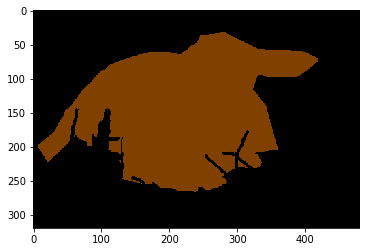

In [43]:
plt.imshow(cm[b.numpy()])

In [44]:
d_test = net(Variable(a.unsqueeze(0).cuda()))

In [45]:
aa = d_test.max(1)[1].squeeze(0)

In [46]:
k = aa.cpu().data.numpy()

In [47]:
aa = cm[k]

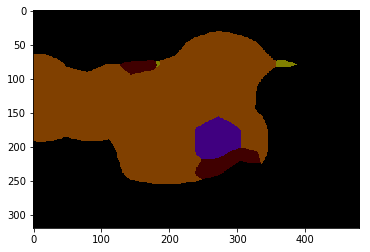

In [48]:
plt.imshow(aa)

In [49]:
torch.save(net.state_dict(), 'simplet_resnet.pth')

In [50]:
torch.save(net, 'test_net.pth')